# Step 01 - Scraping and EDA for Steam Reviews

In [1]:
import numpy as np
import pandas as pd
import json
import spacy
import matplotlib.pyplot as plt
import datetime
import steamreviews

import bbcode
import string
import re

from spacy_langdetect import LanguageDetector

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer

import wordcloud

import gensim

%matplotlib inline

unable to import 'smart_open.gcs', disabling that module


In [197]:
#define params for steamreviews
#steamreviews by woctezuma @ https://github.com/woctezuma/download-steam-reviews/tree/master/steamreviews

request_params = dict()
request_params['filter'] = 'recent'     #recent for reviews written within day_range; updated for reviews updated within day_range
request_params['language'] = 'english'  #input language of choice
request_params['day_range'] = '365'     #get reviews up to 1 year back from current date

app_id = 1174180     #Red Dead Redemption 2 appID

review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id, chosen_request_params=request_params)  #writes to a /data/ folder in same dir as this ipynb

#Caveat: do not expect reliable performance during Steam sales. Steam API will throttle traffic, resulting in 502 Errors.
#After some discussion and testing with the author during Summer Sale (July 2019), he has added error handling features and verbosity option for error reporting

[appID = 1174180] expected #reviews = 21045
Number of queries 150 reached. Cooldown: 310 seconds


In [2]:
#read in data as json file; replace this JSON with any JSON scraped for a steam game using Steam game's JSON
#Caveat: Do not expect many usable results from Free-To-Play (F2P) games. Most reviews on F2P games are essentially spam.
with open('./data/review_1174180.json') as jsonfile:
    jayson = json.load(jsonfile)

In [3]:
review_data = [v for v in jayson['reviews'].values()]
author_key_list = list(review_data[0]['author'].keys())

In [200]:
len(review_data)

21044

In [201]:
#earliest review (according to defined params)
datetime.datetime.utcfromtimestamp(min([review_data[i]['timestamp_created'] for i in range(len(review_data))])).strftime('%Y-%m-%d')

'2019-12-05'

In [203]:
#latest review (as at time when project commenced)
datetime.datetime.utcfromtimestamp(max([review_data[i]['timestamp_created'] for i in range(len(review_data))])).strftime('%Y-%m-%d')

'2020-04-12'

In [204]:
#use this UNIX timestamp to filter out old data when making a test dataset later
max([review_data[i]['timestamp_created'] for i in range(len(review_data))])

1586661820

In [205]:
#preview an entry in the JSON file
review_data[0]

{'recommendationid': '67135457',
 'author': {'steamid': '76561198060617329',
  'num_games_owned': 146,
  'num_reviews': 8,
  'playtime_forever': 6733,
  'playtime_last_two_weeks': 661,
  'last_played': 1586647445},
 'language': 'english',
 'review': 'ONLY FOR HARDCORE GUNSLINGERS',
 'timestamp_created': 1586661820,
 'timestamp_updated': 1586661820,
 'voted_up': True,
 'votes_up': 0,
 'votes_funny': 0,
 'weighted_vote_score': 0,
 'comment_count': 0,
 'steam_purchase': True,
 'received_for_free': False,
 'written_during_early_access': False}

In [4]:
#for definition of each field in the JSON files, visit (here)[https://partner.steamgames.com/doc/store/getreviews]
#tested for loop at first, but comprehensions much faster. Completed the operation within 1 minute vs for loop incomplete after 10 min

steam_dict = {'recommendationid':[review_data[i]['recommendationid'] for i in range(len(review_data))],
              
              'author_steamid':[review_data[i]['author']['steamid'] for i in range(len(review_data))],
              
              'author_num_games_owned':[review_data[i]['author']['num_games_owned'] for i in range(len(review_data))],
              
              'author_num_reviews':[review_data[i]['author']['num_reviews'] for i in range(len(review_data))],
              
              'author_playtime_forever':[review_data[i]['author']['playtime_forever'] for i in range(len(review_data))], 
              #data recorded in minutes - independently verified: https://steamcommunity.com/id/mydogsnameissnowballball/recommended/730/ - 43586 divided by 724.6h on record = 60 min
              
              'author_playtime_last_two_weeks':[review_data[i]['author']['playtime_last_two_weeks'] for i in range(len(review_data))],
              
              'author_last_played':[review_data[i]['author']['last_played'] for i in range(len(review_data))],
              
              'review':[review_data[i]['review'] for i in range(len(review_data))],
              
              'timestamp_created':[review_data[i]['timestamp_created'] for i in range(len(review_data))],
              
              'timestamp_updated':[review_data[i]['timestamp_updated'] for i in range(len(review_data))],
              
              'voted_up':[review_data[i]['voted_up'] for i in range(len(review_data))],
              
              'weighted_vote_score':[review_data[i]['weighted_vote_score'] for i in range(len(review_data))],
              
              'steam_purchase':[review_data[i]['steam_purchase'] for i in range(len(review_data))],
              
              'received_for_free':[review_data[i]['received_for_free'] for i in range(len(review_data))],
              
              'written_during_early_access':[review_data[i]['written_during_early_access'] for i in range(len(review_data))]}

In [5]:
df_raw = pd.DataFrame(steam_dict)
df_raw.head()

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
0,67135457,76561198060617329,146,8,6733,661,1586647445,ONLY FOR HARDCORE GUNSLINGERS,1586661820,1586661820,True,0,True,False,False
1,67132869,76561197969251107,100,8,7254,1265,1586568563,9 out of 10,1586657697,1586657697,True,0,True,False,False
2,67132727,76561198872082587,9,2,873,873,1586657396,Hunting simulator 2019,1586657423,1586657423,True,0,True,False,False
3,67132535,76561197985409267,40,3,11384,6606,1586642933,"Online review only...Simply put, it sucks ass....",1586657138,1586657138,False,0,True,False,False
4,67132405,76561198118371403,134,3,12385,562,1586665388,It's a wonderful multiplayer and singleplayer ...,1586656937,1586656937,False,0,False,False,False


In [208]:
df_raw.shape

(21044, 15)

In [209]:
#check for duplicate reviews

abs(len(df_raw['recommendationid'].unique()) - len(df_raw))

0

In [210]:
df_raw.dtypes

recommendationid                  object
author_steamid                    object
author_num_games_owned             int64
author_num_reviews                 int64
author_playtime_forever            int64
author_playtime_last_two_weeks     int64
author_last_played                 int64
review                            object
timestamp_created                  int64
timestamp_updated                  int64
voted_up                            bool
weighted_vote_score               object
steam_purchase                      bool
received_for_free                   bool
written_during_early_access         bool
dtype: object

In [6]:
#Paying players have more reasons to give frank reviews
df_raw_paid = df_raw[df_raw['received_for_free']==False] # Redundant for F2P games. Nobody can buy them; anybody can review them.

In [7]:
df_raw_free = df_raw[df_raw['received_for_free']==True]

In [9]:
df_raw_paid.count()

recommendationid                  20631
author_steamid                    20631
author_num_games_owned            20631
author_num_reviews                20631
author_playtime_forever           20631
author_playtime_last_two_weeks    20631
author_last_played                20631
review                            20631
timestamp_created                 20631
timestamp_updated                 20631
voted_up                          20631
weighted_vote_score               20631
steam_purchase                    20631
received_for_free                 20631
written_during_early_access       20631
dtype: int64

In [10]:
df_raw_free.count()

recommendationid                  413
author_steamid                    413
author_num_games_owned            413
author_num_reviews                413
author_playtime_forever           413
author_playtime_last_two_weeks    413
author_last_played                413
review                            413
timestamp_created                 413
timestamp_updated                 413
voted_up                          413
weighted_vote_score               413
steam_purchase                    413
received_for_free                 413
written_during_early_access       413
dtype: int64

In [11]:
df_raw_free

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
60,67104119,76561199021811513,5,3,318,318,1586593462,it's good,1586622346,1586622346,True,0,True,True,False
117,67052692,76561198438862116,5,1,1073,1073,1586640128,Best game with amazing story and spectacular g...,1586555645,1586555645,True,0,True,True,False
176,67005424,76561198054186047,49,23,713,297,1586584970,Should be rated as a pre-alpha stage as online...,1586500545,1586500545,False,0.47413790225982666,False,True,False
240,66967195,76561198142710070,3,1,3682,2377,1586100890,Game shutters a lot after playing 70 percent o...,1586450043,1586450043,False,0,True,True,False
259,66950229,76561199009283622,6,1,13421,5314,1586595564,"graphic,story,exciting, the best game ever",1586431078,1586431078,True,0.52144467830657959,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20740,59316434,76561198029176016,312,5,3927,0,1577082606,Great console port. Even includes the 30fps,1575596264,1575597809,False,0.587306737899780273,False,True,False
20820,59311151,76561198108774962,61,12,5707,120,1585776027,"This game is indeed a masterpiece, by far one ...",1575588153,1575821555,True,0.545454561710357666,False,True,False
20948,59302245,76561198275463014,267,13,219,0,1575813052,yuuuumi western travel simulator looks really ...,1575577246,1575603294,True,0.519999980926513672,True,True,False
20975,59300198,76561198116100475,2244,275,3128,0,1578272720,From what I’ve heard the pc launch was poor I’...,1575575014,1576957550,True,0.583271384239196777,False,True,False


In [12]:
#check class balance of player-provided sentiment label
df_raw_free['voted_up'].value_counts(normalize=True)

True     0.830508
False    0.169492
Name: voted_up, dtype: float64

In [13]:
df_raw_paid['voted_up'].value_counts(normalize=True)

True     0.769861
False    0.230139
Name: voted_up, dtype: float64

In [213]:
df_raw['recommendationid'] = df_raw['recommendationid'].map(lambda x: str(x))
df_raw['author_steamid'] = df_raw['author_steamid'].map(lambda x: str(x))
#df_raw['author_last_played'] = df_raw['author_last_played'].map(lambda x: str(x))
#df_raw['timestamp_created'] = df_raw['timestamp_created'].map(lambda x: str(x))
#df_raw['timestamp_updated'] = df_raw['timestamp_updated'].map(lambda x: str(x))
df_raw['weighted_vote_score'] = df_raw['weighted_vote_score'].map(lambda x: float(x)) # vote score is string -- change to float for plotting

In [214]:
df_raw['weighted_vote_score'].dtype

dtype('float64')

(array([1.0953e+04, 3.0000e+00, 2.4000e+01, 1.6700e+02, 2.4290e+03,
        6.7130e+03, 2.1600e+02, 6.2000e+01, 4.2000e+01, 2.2000e+01]),
 array([0.        , 0.09600095, 0.19200189, 0.28800284, 0.38400378,
        0.48000473, 0.57600567, 0.67200662, 0.76800756, 0.86400851,
        0.96000946]),
 <a list of 10 Patch objects>)

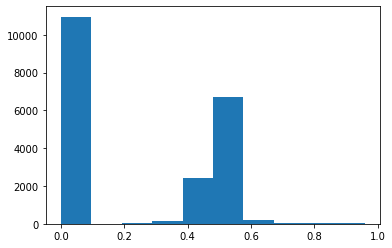

In [215]:
plt.hist(df_raw['weighted_vote_score'])

In [216]:
#check if players purchased this game on steam 
#possible for games to be purchased on other sites and be redeemed on Steam

df_raw['steam_purchase'].value_counts(normalize=True) #Possibly redundant for F2P games

True     0.93311
False    0.06689
Name: steam_purchase, dtype: float64

In [217]:
#earliest review from remaining data
datetime.datetime.utcfromtimestamp(min(df_raw['timestamp_created'])).strftime('%Y-%m-%d %H:%M:%S')

'2019-12-05 17:22:40'

In [218]:
#check how many unique reviews remain
len(df_raw['recommendationid'].unique())

20631

In [219]:
#Convert author playtime data to hours (recorded in minutes in JSON)

df_raw['author_playtime_forever']=df_raw['author_playtime_forever']/60

df_raw['author_playtime_last_two_weeks']=df_raw['author_playtime_last_two_weeks']/60

In [220]:
df_raw['review_length'] = df_raw['review'].map(lambda x: len(x.split()))

In [221]:
df_raw.describe()

,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,timestamp_created,timestamp_updated,weighted_vote_score,review_length
count,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,2.063100e+04,2.063100e+04,20631.000000,20631.000000
mean,171.063739,10.864524,101.619266,6.849303,1.583245e+09,1.579395e+09,1.579624e+09,0.236782,50.170714
std,325.369584,21.362851,116.858864,19.790475,3.220917e+06,3.171550e+06,3.208190e+06,0.254581,106.130208
min,0.000000,1.000000,0.083333,0.000000,1.575570e+09,1.575567e+09,1.575567e+09,0.000000,0.000000
25%,38.000000,2.000000,33.200000,0.000000,1.580708e+09,1.576913e+09,1.577063e+09,0.000000,4.000000
50%,92.000000,5.000000,70.416667,0.000000,1.584331e+09,1.578261e+09,1.578612e+09,0.000000,16.000000
75%,197.000000,11.000000,127.075000,1.900000,1.586145e+09,1.581290e+09,1.581718e+09,0.503173,52.000000
max,11940.000000,811.000000,1976.950000,324.266667,1.586666e+09,1.586662e+09,1.586663e+09,0.960009,2632.000000


In [222]:
#descriptive summary for raw reviews, before filtering

raw_data = df_raw.describe()[['author_num_games_owned','author_playtime_forever','author_playtime_last_two_weeks','review_length']]

for col in raw_data:
    raw_data[col] = raw_data[col].map(lambda x: round(x,2))

raw_data

,author_num_games_owned,author_playtime_forever,author_playtime_last_two_weeks,review_length
count,20631.00,20631.00,20631.00,20631.00
mean,171.06,101.62,6.85,50.17
std,325.37,116.86,19.79,106.13
min,0.00,0.08,0.00,0.00
25%,38.00,33.20,0.00,4.00
50%,92.00,70.42,0.00,16.00
75%,197.00,127.07,1.90,52.00
max,11940.00,1976.95,324.27,2632.00


In [223]:
df_raw_num = df_raw.select_dtypes(exclude=['O','bool'])

In [224]:
#Keep only data for players who:
#played more than 2 hours and 
#played at least 30 min of the game in 2 weeks preceding submission of review


df_raw_num_high_play = df_raw_num[(df_raw_num['author_playtime_forever']>2) & (df_raw_num['author_playtime_last_two_weeks']>=0.5)]

In [225]:
len(df_raw_num_high_play)

6444

In [226]:
#summarise the remaining data
df_raw_num_high_play.describe()

,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,timestamp_created,timestamp_updated,weighted_vote_score,review_length
count,6444.000000,6444.000000,6444.000000,6444.000000,6.444000e+03,6.444000e+03,6.444000e+03,6444.000000,6444.000000
mean,130.627871,9.114060,145.596472,21.890622,1.586338e+09,1.581142e+09,1.581470e+09,0.204001,45.141527
std,276.394054,19.564628,157.895781,30.413929,3.517427e+05,3.715010e+06,3.672942e+06,0.251291,98.509561
min,1.000000,1.000000,2.050000,0.500000,1.585458e+09,1.575569e+09,1.575569e+09,0.000000,0.000000
25%,25.000000,2.000000,54.270833,2.562500,1.586106e+09,1.577609e+09,1.577893e+09,0.000000,4.000000
50%,65.000000,4.000000,99.425000,9.908333,1.586490e+09,1.580867e+09,1.581389e+09,0.000000,13.000000
75%,151.000000,9.000000,179.820833,29.750000,1.586630e+09,1.585059e+09,1.585175e+09,0.498812,44.000000
max,11940.000000,811.000000,1976.950000,324.266667,1.586666e+09,1.586662e+09,1.586663e+09,0.960009,1474.000000


(array([1.120e+03, 1.525e+03, 1.173e+03, 7.300e+02, 5.080e+02, 3.600e+02,
        2.390e+02, 1.960e+02, 1.300e+02, 9.600e+01, 7.400e+01, 5.300e+01,
        4.200e+01, 2.400e+01, 1.800e+01, 2.800e+01, 1.500e+01, 1.700e+01,
        1.800e+01, 1.500e+01, 1.400e+01, 4.000e+00, 8.000e+00, 4.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00, 8.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([   2.05 ,   41.548,   81.046,  120.544,  160.042,  199.54 ,
         239.038,  278.536,  318.034,  357.532,  397.03 ,  436.528,
         476.026,  515.524,  555.022,  594.52 ,  634.018,  673.516,
         713.014,  752.512,  792.01 ,  831.508,  871.006,  910.504,
         950.002,  989.5  , 1028.998, 1068.496, 1107.994, 1147.492,
        1186.99 , 1226.488, 1265.986

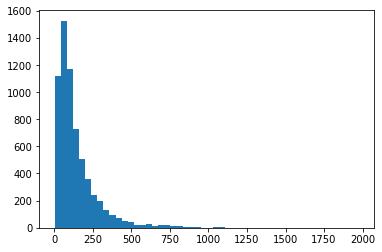

In [227]:
plt.hist(df_raw_num_high_play['author_playtime_forever'],bins=50)

# Selecting data by player game time

Most players on this game have 2 to ~765 hours on record from the time they began playing, and all reviewers played at least 30 minutes (enough time for a battle) in the past 2 weeks.

Recent information is more important, and opinions are more reliable when players have recently played the game.

In [228]:
#extract usable data; save as new df
df_usable = df_raw[(df_raw['author_playtime_forever']>=3)& (df_raw_num['author_playtime_last_two_weeks']>=(10/60))] #setting cutoff to 3 hours of playtime to be safe
df_usable.head(2)

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access,review_length
0,67135457,76561198060617329,146,8,112.216667,11.016667,1586647445,ONLY FOR HARDCORE GUNSLINGERS,1586661820,1586661820,True,0.0,True,False,False,4
1,67132869,76561197969251107,100,8,120.900000,21.083333,1586568563,9 out of 10,1586657697,1586657697,True,0.0,True,False,False,4


In [229]:
#preview first review
df_usable.iloc[0,7]

'ONLY FOR HARDCORE GUNSLINGERS'

In [230]:
df_usable['review'].describe()

count     7033
unique    6444
top       good
freq        47
Name: review, dtype: object

In [231]:
#some duplicate reviews exist, but we will deal with them later.

review_lengths = [len(x.split()) for x in df_usable['review']]
print(len(review_lengths)) #no of reviews
print(sum(review_lengths)/len(review_lengths)) #mean character length of a review
df_usable['review_length']=df_usable['review'].map(lambda x: len(x.split()))

7033
45.393288781458836


C:\Users\Henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([5.929e+03, 5.970e+02, 2.190e+02, 1.120e+02, 6.100e+01, 4.000e+01,
        2.200e+01, 1.100e+01, 1.300e+01, 9.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        5.000e+00, 4.000e+00]),
 array([   0. ,   73.7,  147.4,  221.1,  294.8,  368.5,  442.2,  515.9,
         589.6,  663.3,  737. ,  810.7,  884.4,  958.1, 1031.8, 1105.5,
        1179.2, 1252.9, 1326.6, 1400.3, 1474. ]),
 <a list of 20 Patch objects>)

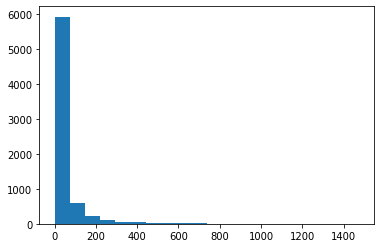

In [232]:
#plot distribution of review lengths -- longer reviews more usable

plt.hist(df_usable['review_length'],bins=20)

In [233]:
df_usable.describe()

,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,timestamp_created,timestamp_updated,weighted_vote_score,review_length
count,7033.000000,7033.000000,7033.000000,7033.000000,7.033000e+03,7.033000e+03,7.033000e+03,7033.000000,7033.000000
mean,132.112328,9.198208,142.599993,20.081831,1.586315e+09,1.580984e+09,1.581303e+09,0.205022,45.393289
std,272.399141,19.292756,154.110550,29.720796,3.606168e+05,3.692306e+06,3.656100e+06,0.251257,100.109134
min,1.000000,1.000000,3.033333,0.166667,1.585458e+09,1.575568e+09,1.575568e+09,0.000000,0.000000
25%,26.000000,2.000000,53.266667,1.683333,1.586059e+09,1.577540e+09,1.577798e+09,0.000000,4.000000
50%,66.000000,4.000000,97.766667,7.933333,1.586459e+09,1.580658e+09,1.581134e+09,0.000000,13.000000
75%,152.000000,9.000000,176.666667,26.983333,1.586626e+09,1.584920e+09,1.585075e+09,0.498812,44.000000
max,11940.000000,811.000000,1976.950000,324.266667,1.586666e+09,1.586662e+09,1.586663e+09,0.960009,1474.000000


In [234]:
#descriptive summary for filtered reviews

high_play_data = df_usable.describe()[['author_num_games_owned','author_playtime_forever','author_playtime_last_two_weeks','review_length']]

for col in high_play_data:
    high_play_data[col] = high_play_data[col].map(lambda x: round(x,2))

high_play_data

,author_num_games_owned,author_playtime_forever,author_playtime_last_two_weeks,review_length
count,7033.00,7033.00,7033.00,7033.00
mean,132.11,142.60,20.08,45.39
std,272.40,154.11,29.72,100.11
min,1.00,3.03,0.17,0.00
25%,26.00,53.27,1.68,4.00
50%,66.00,97.77,7.93,13.00
75%,152.00,176.67,26.98,44.00
max,11940.00,1976.95,324.27,1474.00


In [235]:
#cut off review lengths at the 25th percentile. 
#Short reviews contain too little info, but we can't discard too much data either.

np.percentile(df_usable['review_length'],25)

4.0

In [236]:
#get data where review is longer than reviews at 25th percentile
df_ready = df_usable[df_usable['review_length']>np.percentile(df_usable['review_length'],25)].reset_index(drop=True) #Remove very short reviews that are likely to be junk

In [237]:
print('Min length:',min(df_ready['review_length']),'words') #shortest review length. 
df_ready.head()

Min length: 5 words


,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access,review_length
0,67132535,76561197985409267,40,3,189.733333,110.100000,1586642933,"Online review only...Simply put, it sucks ass....",1586657138,1586657138,False,0.0,True,False,False,97
1,67132405,76561198118371403,134,3,206.416667,9.366667,1586665388,It's a wonderful multiplayer and singleplayer ...,1586656937,1586656937,False,0.0,False,False,False,33
2,67132358,76561198133325331,22,2,61.283333,11.300000,1586664692,People claim a lot in reviews that they cant r...,1586656864,1586656864,True,0.0,True,False,False,75
3,67131607,76561198356409172,169,4,62.516667,35.016667,1586564392,"Best fucking story I have ever played, online'...",1586655683,1586655683,True,0.0,True,False,False,13
4,67131279,76561198807193879,27,1,36.650000,23.400000,1586664358,well made game lots of fun,1586655188,1586655188,True,0.0,True,False,False,6


In [238]:
#Check how much data remains
len(df_ready)

4989

In [239]:
#descriptive summary for filtered reviews

ready_data = df_ready.describe()[['author_num_games_owned','author_playtime_forever','author_playtime_last_two_weeks','review_length']]

for col in ready_data:
    ready_data[col] = ready_data[col].map(lambda x: round(x,2))

ready_data

,author_num_games_owned,author_playtime_forever,author_playtime_last_two_weeks,review_length
count,4989.00,4989.00,4989.00,4989.00
mean,148.14,150.54,20.43,63.12
std,306.69,160.24,30.63,114.22
min,1.00,3.12,0.17,5.00
25%,30.00,57.18,1.68,11.00
50%,76.00,103.93,8.03,26.00
75%,169.00,188.97,27.48,65.00
max,11940.00,1976.95,324.27,1474.00


(array([3.945e+03, 5.550e+02, 2.080e+02, 1.070e+02, 6.200e+01, 3.800e+01,
        2.200e+01, 1.000e+01, 1.300e+01, 9.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        5.000e+00, 4.000e+00]),
 array([   5.  ,   78.45,  151.9 ,  225.35,  298.8 ,  372.25,  445.7 ,
         519.15,  592.6 ,  666.05,  739.5 ,  812.95,  886.4 ,  959.85,
        1033.3 , 1106.75, 1180.2 , 1253.65, 1327.1 , 1400.55, 1474.  ]),
 <a list of 20 Patch objects>)

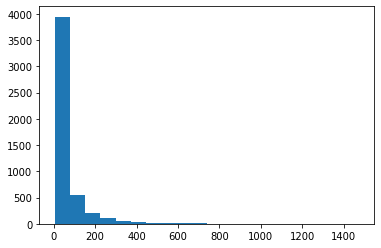

In [240]:
#Dropped more than half the total dataset, but remaining reviews should be highly usable.

plt.hist(df_ready['review_length'],bins=20)

In [241]:
#preview 1 review
df_ready.iloc[1,7] #Most reviews are between 4 and 200 words long.

"It's a wonderful multiplayer and singleplayer game, but until they fix all their awful connection issues I have to just not recommend it. I mean, you wouldn't recommend a headache to your friend."

In [242]:
#summarise the new df
df_ready['review'].describe()

count                                       4989
unique                                      4982
top       one of the best games I've ever played
freq                                           2
Name: review, dtype: object

In [243]:
#What are the 10 most duplicated reviews?
#Steam reviews tend to be spammy 
df_ready['review'].value_counts()[:10]

one of the best games I've ever played                                                                          2
Best game ive ever played                                                                                       2
You have been disconnected from Red Dead Online due to a fault on Rockstar game services (Error: 0x20010006)    2
I wanna be a cowboy baby!                                                                                       2
One of the best games I've ever played                                                                          2
One of the best games ever <3                                                                                   2
There's a snake in my boot.                                                                                     2
It's more than just a game!                                                                                     1
50 HOURS IN\n\n1000 HOURS MORE TO GO                                                    

### Review Spam/Ham Problem
- Some reviews have been spammed multiple times, or just happen to come out the same.
- All reviewers' opinions are important, but repeated reviews sometimes originate from one player. 
- Removing duplicates controls the "vocal minority" problem effectively.
- Need to clean away any text that is not strictly English. It is possible for text from other languages to be wrongly labelled as English. (Reviews scraped were all labelled as being in English)

In [244]:
#drop duplicate entries in reviews, because they are considered spam
df_cleaning = df_ready.drop_duplicates(subset=['author_steamid','review'])

In [245]:
df_cleaning.select_dtypes(include='O').describe()

,recommendationid,author_steamid,review
count,4989,4989,4989
unique,4989,4989,4982
top,66759058,76561198143909397,one of the best games I've ever played
freq,1,1,2


In [246]:
deduplicated_rows = abs(len(df_cleaning) - len(df_ready)) #find out how many rows were removed during deduplication
print(deduplicated_rows)
print(deduplicated_rows/len(df_ready)) #Percentage of data that was duplicated

0
0.0


### De-Duplication

Rigorous as our check was, no rows were dropped just because the text was exactly the same.

It appears that a hanadful of unique reviewers have written the same review by random chance, or some players use multiple accounts to post the same text.

# Language Cleaning

Just to be absolutely sure all text is in English, we will do language detection. 

In [247]:
import en_core_web_sm

In [248]:
#get languages by document
nlp = en_core_web_sm.load()
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)
    
def get_lang_doc(text): #gets average language probability scores and returns highest-ranked language
    doc = nlp(text)
    return doc._.language['language']

#count languages for sentences in document
def get_langs_sent(text):
    langs={}
    lang_st={}
    doc = nlp(text)
    
    for i, sent in enumerate(doc.sents):
        langs[i]=sent._.language['language'] #Iterating through sentence level, thus only need to add language. Probability scores should be quite high per sentence.
    
    lang_st = list(set(langs.values())) #Get language code of each language that appeared. As long as more than 1 language appears, the review will be excluded.
    
    return lang_st

In [249]:
#test the language detection function

dc=df_cleaning['review'][np.random.randint(0,len(df_cleaning['review']))]
doc=nlp(dc)
print(dc+'\n-----')
print(doc._.language)

200 hours in and still have found only one moose
-----
{'language': 'en', 'score': 0.9999989674563854}


In [250]:
for i in range(3):
    random_select = np.random.randint(0,len(df_cleaning['review']))
    print(random_select)
    print(df_cleaning['review'][random_select])
    langs = get_langs_sent(df_cleaning['review'][random_select])
    print(langs)
    print()

3807
Best game i've played this year, if not the best i've ever played. Amazing story, gameplay, combat. I can't stop playing it!
['en']

434
The story is good up until about the halfway point, then it becomes a shootout simulator. Gameplay is okay, graphics are great, the multiplayer is well let's not talk about that. I prefer Red Dead 1 but this is good too.


['en']

4136
great, but you need some graphics horsepower
['en']



In [251]:
#test langdetect by sentence
random_select = np.random.randint(0,len(df_cleaning['review']))
print(random_select)
print(df_cleaning['review'][random_select])
get_langs_sent(df_cleaning['review'][random_select])

3908
Overall, not recommended. The game crashing bugs are the first problem, but if you can get past those, the multiplayer bugs are the next issue.

My game breaking bug was the infamous STATUS_ACCESS_VIOLATION. No amount of searching could find a suitable fix to this bug. The following solutions were found online in articles and forums and are confirmed to NOT WORK. SKIP THESE 'FIXES'. 

Run game as admin
Run launcher as admin
Optimize GFX settings
Heat monitoring
Update BIOS
Update GPU Drivers
Command Line -scoffline
Add -memrestrict 621945600 to launcher options
Reinstall latest GPU Drivers
Clean install of game and verify cache
Downgrade Razer Synapse to 2.0
Update Asus Aura to latest version
Uninstall Asus Aura
Disable ingame keyboard lighting
Disable MSAA in game
Disable NVIDIA DSR in control panel
Return RAM speed to stock clockspeed
Re-enable XMP 2.0
CLEAN install of old Nvidia Drivers 431.36
Run System File Checker
Run Windows Memory Diagnostics
Disable Antivirus temporarily


['en', 'de', 'it', 'tl']

In [252]:
#get languages by document for the same review

test_review = df_cleaning['review'][2160]
get_lang_doc(test_review)

'en'

In [253]:
#In most cases, only English will be detected. Sometimes, get_langs_sent throw false positives like in the above examples.
#Also heavy on operations; slows computation down.
#Trying doc langs instead.

trial_doc_langs = df_cleaning['review'][:5].map(lambda x: get_lang_doc(x))

In [254]:
trial_doc_langs

0    en
1    en
2    en
3    en
4    en
Name: review, dtype: object

In [255]:
#doc_langs will be used from here on. 
#Some risk of losing data due to bits of foreign language text, but acceptable if it does not drop too much data.

doc_langs = [get_lang_doc(x) for x in df_cleaning['review']] #WARNING: SLOW! May take a couple of minutes to finish.

In [256]:
df_cleaning['review_lang']=doc_langs

In [257]:
df_cleaning.to_csv('./dataframes/df_cleaning.csv') #saving so I don't have to run the cleaning operation again

In [258]:
df_cleaning = pd.read_csv('./dataframes/df_cleaning.csv',index_col=0)

In [259]:
df_langs_cleaned = df_cleaning[df_cleaning['review_lang']=='en'].reset_index(drop=True)
len(df_langs_cleaned)

4836

In [260]:
mult_ln_reviews_dropped = (len(df_cleaning) - len(df_langs_cleaned))/len(df_cleaning)
print(mult_ln_reviews_dropped)

0.030667468430547205


### Dropped multi-lingual reviews

### Text cleaning

Steam reviews use BBCode, a form of markup language used to format bulletin board posts (hence the name). 

Regex can be used to clean this out, but there is a pre-built package for this exact purpose.

No need to reinvent the wheel.

In [261]:
parser=bbcode.Parser()

In [262]:
#expand contractions e.g. can't, won't to cannot, will not
#easier to remove stopwords

#Source: https://gist.github.com/nealrs/96342d8231b75cf4bb82 (Modified for my own use)


with open('./en_contractions/contra_dict.txt') as contra_dict:  #open pre-defined dictionary of english contractions, saved separately to avoid clutter
    cList = json.load(contra_dict)

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text.lower())

In [263]:
#define stopwords (common words with no meaning by themselves)

num_dict = {'0':'zero',
            '1':'one',
            '2':'two',
            '3':'three',
            #'i':'one',      skipped. Using Roman numeral 'i' will conflict with the pronoun "I", which is not a number
            'ii':'two',
            'iii':'three'   
            }

def num2word(d):
    
    if (len(d) == 1 and d in '0123')  or (d in ['ii','iii']):
        word = num_dict[d]
    
    elif (len(str(d))==1 and str(d) in '0123'):
        word = num_dict(str(d))
    
    else:
        word = d
    
    return word

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]    #retain these for making n-grams

def remove_stopwords(doc):
    words = [num2word(w) for w in doc if w != '' and w not in en_stopwords]
    return words

In [264]:
def parse_clean(text):
    parsed_text = parser.strip(text) #remove BBcode notations from text
    
    text = expandContractions(parsed_text) #expand contractions; return all text in lower case
    
    text = re.split(r'\W+',text) #separate words from punctuation (e.g. remove 's from "Cao Cao's")
    
    text = [num2word(w) for w in text] #convert single digits to words before word len check, or they will be lost
    
    #All word lengths should be >1 character and <= length of the longest word in the English language. It's common for people spam incoherent letters on the Internet.
    text = [word for word in text if word not in en_stopwords and len(word)>1 and len(word) <= len('pneumonoultramicroscopicsilicovolcanoconiosis')] 
    
    #clean_text = [num2word(w) for w in text] #just in case any lone numbers appeared after cleaning
    
    return text

In [265]:
#creating a test review to make sure parse_clean() works as intended

se="I like Total War: 3 Kingdoms. \n1. I enjoyed making myself Emperor of China! Would be nice if there was more story. \n2. Ma Teng is OP. \n3. DO NOT PURSUE LU BU. \n4. Cao Cao's proxy war ability is awesome."
print(parse_clean(se))

# doc=nlp(se)
# print([(X.text, X.label_) for X in doc.ents]) # These 2 lines may be useful later.

['total', 'war', 'three', 'kingdoms', 'one', 'enjoyed', 'making', 'emperor', 'china', 'nice', 'story', 'two', 'ma', 'teng', 'op', 'three', 'pursue', 'lu', 'bu', 'cao', 'cao', 'proxy', 'war', 'ability', 'awesome']


In [266]:
txt = df_cleaning['review'][np.random.randint(0,len(df_cleaning))]
print(txt,'\n')
print(parse_clean(txt))

I hate Rockstar, but this is beautiful. 

['hate', 'rockstar', 'beautiful']


In [267]:
df_langs_cleaned['clean_reviews'] = df_langs_cleaned['review'].map(lambda x: parse_clean(x))

In [270]:
df_langs_cleaned.head(2)

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access,review_length,review_lang,clean_reviews
0,67132535,76561197985409267,40,3,189.733333,110.100000,1586642933,"Online review only...Simply put, it sucks ass....",1586657138,1586657138,False,0.0,True,False,False,97,en,"[online, review, simply, sucks, ass, glitches,..."
1,67132405,76561198118371403,134,3,206.416667,9.366667,1586665388,It's a wonderful multiplayer and singleplayer ...,1586656937,1586656937,False,0.0,False,False,False,33,en,"[wonderful, multiplayer, singleplayer, fix, aw..."


In [271]:
#Save!
df_langs_cleaned.to_csv('./dataframes/df_langs_cleaned.csv')

In [272]:
final_df = pd.read_csv('./dataframes/df_langs_cleaned.csv',index_col=0)

In [273]:
final_df = final_df[['timestamp_created','review','clean_reviews']]
final_df.head()

,timestamp_created,review,clean_reviews
0,1586657138,"Online review only...Simply put, it sucks ass....","['online', 'review', 'simply', 'sucks', 'ass',..."
1,1586656937,It's a wonderful multiplayer and singleplayer ...,"['wonderful', 'multiplayer', 'singleplayer', '..."
2,1586656864,People claim a lot in reviews that they cant r...,"['people', 'claim', 'reviews', 'run', 'works',..."
3,1586655683,"Best fucking story I have ever played, online'...","['best', 'fucking', 'story', 'played', 'online..."
4,1586655188,well made game lots of fun,"['lots', 'fun']"


In [274]:
final_df['clean_reviews'] = final_df['clean_reviews'].map(lambda x: ''.join(c for c in x if c not in string.punctuation).split()) 
#Reading in the DF from a CSV turned the list of words in each cell into string, so we have to remove the punctuation and split them again

In [275]:
final_df.head()

,timestamp_created,review,clean_reviews
0,1586657138,"Online review only...Simply put, it sucks ass....","[online, review, simply, sucks, ass, glitches,..."
1,1586656937,It's a wonderful multiplayer and singleplayer ...,"[wonderful, multiplayer, singleplayer, fix, aw..."
2,1586656864,People claim a lot in reviews that they cant r...,"[people, claim, reviews, run, works, fine, tim..."
3,1586655683,"Best fucking story I have ever played, online'...","[best, fucking, story, played, online, cool, w..."
4,1586655188,well made game lots of fun,"[lots, fun]"


In [276]:
#Time to explore the corpus word frequency.
#Get all words in the corpus

word_lst = []
for i in final_df['clean_reviews']:
    word_lst.extend(i)
    
cleaned_words = word_lst

print(len(word_lst))

132577


In [277]:
#100 most common words in the corpus
wordfreq = nltk.FreqDist(word_lst)
# Print the most common words.
print(wordfreq.most_common(100))

[('story', 1993), ('online', 1606), ('play', 1289), ('rockstar', 1263), ('one', 1263), ('time', 1052), ('pc', 919), ('10', 908), ('best', 882), ('games', 808), ('played', 795), ('hours', 791), ('fun', 761), ('graphics', 760), ('two', 704), ('world', 702), ('amazing', 688), ('dead', 590), ('mode', 559), ('issues', 557), ('playing', 549), ('red', 540), ('bugs', 531), ('recommend', 499), ('player', 494), ('buy', 488), ('settings', 487), ('horse', 478), ('crashes', 471), ('people', 464), ('gameplay', 459), ('missions', 450), ('single', 448), ('worth', 442), ('experience', 436), ('far', 436), ('gta', 430), ('love', 425), ('money', 410), ('things', 403), ('want', 402), ('got', 389), ('run', 389), ('way', 372), ('three', 365), ('fps', 350), ('open', 346), ('beautiful', 343), ('bad', 341), ('td', 322), ('fix', 316), ('redemption', 310), ('review', 305), ('times', 302), ('pretty', 302), ('rdr2', 302), ('long', 299), ('characters', 297), ('work', 291), ('need', 284), ('mission', 281), ('high', 2

# First Word Cloud

1st Word Cloud does not seem very coherent. 

Perhaps creating phrases (n-grams) will increase coherence.

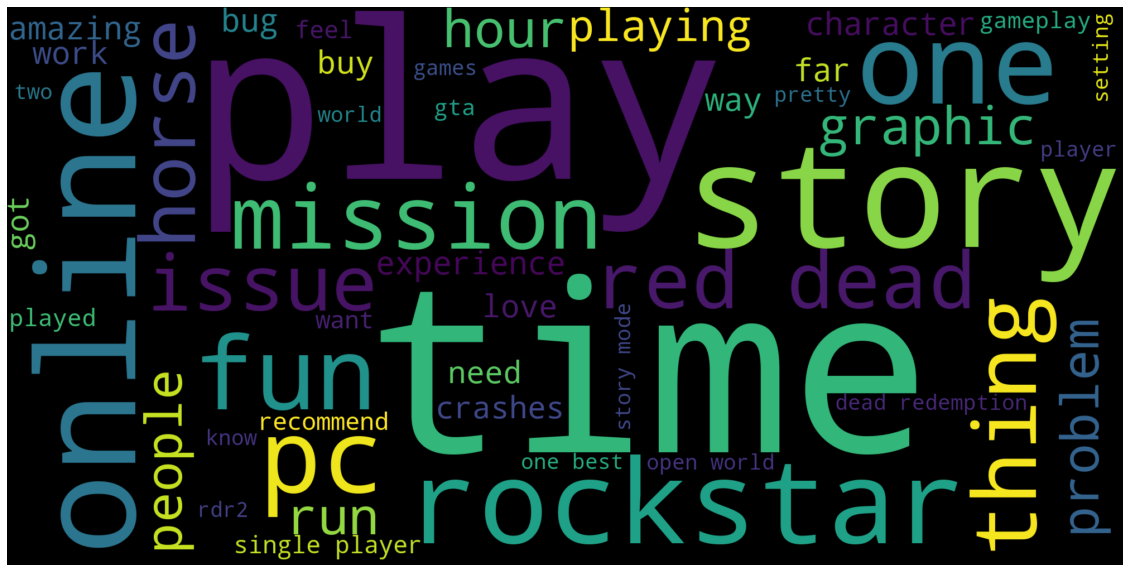

In [278]:
#turn the word list into a str for wordcloud generation
text = ' '.join(w for w in word_lst)

# Create and generate a word cloud image:
wcd = wordcloud.WordCloud(width = 2000, height=1000, max_words = 50).generate(text)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

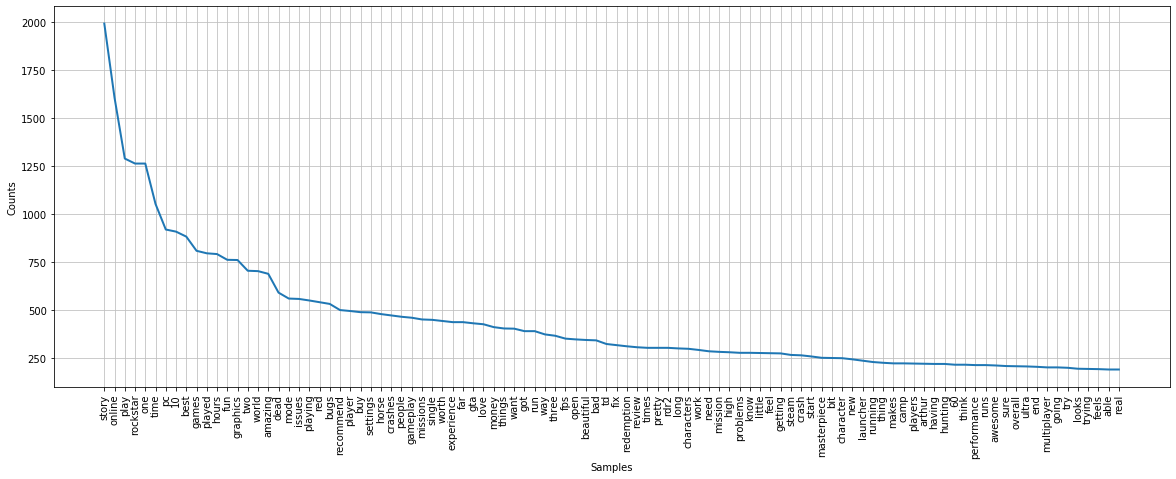

In [279]:
plt.figure(figsize=(20,7))
wordfreq.plot(100,cumulative=False)

In [280]:
# Credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this code

# Build the bigram and trigram models
bigram = gensim.models.Phrases(list(final_df['clean_reviews']), min_count=5, threshold=10) # feed a list of lists of words e.g. [['word1','word2'],['word3','word4'] to train generator model]
trigram = gensim.models.Phrases(bigram[list(final_df['clean_reviews'])], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Word Frequencies

While it can be seen that the stopwords made the word clouds have clearer terms, we will take a step back and make n-grams before we remove stopwords and numbers, and lemmatise text.

This is just in case any of these words form part of an n-gram that may prove crucial to more accurate analysis later.

In [281]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [282]:
def lemma(bow):
    
    #Use SpaCy lemmatiser to lemmatise words.
    lemma_doc = nlp(" ".join(bow)) 

    lemma_text = [token.text if '_' in token.text else token.lemma_ for token in lemma_doc if token.lemma_ != '-PRON-']    #ignore n-grams and pronouns
    
    return lemma_text

In [283]:
def stop_lemma(text):
    text = remove_stopwords(text)
    text = lemma(text)
    return text

#remove newly-added stopwords from clean reviews only after getting bigrams and trigrams just in case those stopwords happen to be part of any n-grams.
#After that, lemmatise.
#Any remaining numbers can be removed at this point, as they are unlikely to be part of any helpful terms.

In [284]:
#testing bigram function
t = [['three', 'kingdoms', 'period'],['romance', 'three', 'kingdoms'],['three', 'kingdoms', 'strategy'],['romance', 'three', 'kingdoms'],
     ['romance','three', 'kingdoms'],['three', 'kingdoms', 'strategy'],['total_war','three', 'kingdoms'],['3', 'kingdoms', 'period'],['three','kingdoms']]

print(make_bigrams(t))

[['three', 'kingdoms', 'period'], ['romance', 'three', 'kingdoms'], ['three', 'kingdoms', 'strategy'], ['romance', 'three', 'kingdoms'], ['romance', 'three', 'kingdoms'], ['three', 'kingdoms', 'strategy'], ['total_war', 'three', 'kingdoms'], ['3', 'kingdoms', 'period'], ['three', 'kingdoms']]


In [285]:
#turning numbers into words was a good idea.
#3grams seem more coherent in general.
#consider adding more stopwords to be cleaned out of the corpus

en_stopwords.extend(['one','two','three']) #removing numbers after making n-grams should reduce noise. 

In [286]:
final_df.head()

,timestamp_created,review,clean_reviews
0,1586657138,"Online review only...Simply put, it sucks ass....","[online, review, simply, sucks, ass, glitches,..."
1,1586656937,It's a wonderful multiplayer and singleplayer ...,"[wonderful, multiplayer, singleplayer, fix, aw..."
2,1586656864,People claim a lot in reviews that they cant r...,"[people, claim, reviews, run, works, fine, tim..."
3,1586655683,"Best fucking story I have ever played, online'...","[best, fucking, story, played, online, cool, w..."
4,1586655188,well made game lots of fun,"[lots, fun]"


In [287]:
final_df['2gram_reviews'] = make_bigrams(final_df['clean_reviews'])

In [288]:
final_df['3gram_reviews'] = make_trigrams(final_df['clean_reviews'])

In [289]:
final_df['2gram_reviews'] = final_df['2gram_reviews'].map(lambda x: stop_lemma(x))
final_df['3gram_reviews'] = final_df['3gram_reviews'].map(lambda x: stop_lemma(x))

In [290]:
final_df.head(2)

,timestamp_created,review,clean_reviews,2gram_reviews,3gram_reviews
0,1586657138,"Online review only...Simply put, it sucks ass....","[online, review, simply, sucks, ass, glitches,...","[online, review, simply, suck, ass, glitche, m...","[online, review, simply, suck, ass, glitche, m..."
1,1586656937,It's a wonderful multiplayer and singleplayer ...,"[wonderful, multiplayer, singleplayer, fix, aw...","[wonderful, multiplayer, singleplayer, fix, aw...","[wonderful, multiplayer, singleplayer, fix, aw..."


In [291]:
#check if this cell still has pronoun tag from lemmatising "im" into '-PRON-' and "be", separating the pronoun and verb
final_df['3gram_reviews'][18]

['worth_penny']

In [292]:
final_df.to_csv('./dataframes/final_df.csv')

In [293]:
word_lst_2gram = []
for i in final_df['2gram_reviews']:
    word_lst_2gram.extend(i)
    
word_lst_3gram = []
for i in final_df['3gram_reviews']:
    word_lst_3gram.extend(i)

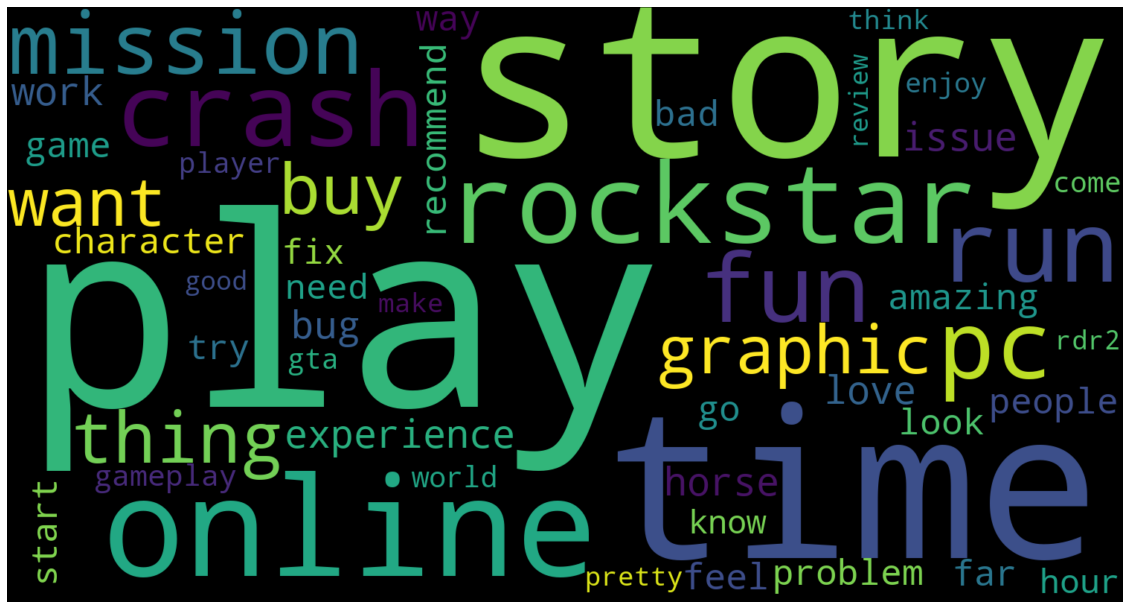

In [294]:
#generate wordcloud for 2grams
text_2grams = ' '.join(w for w in word_lst_2gram)

# Create and generate a word cloud image
wcd = wordcloud.WordCloud(width = 1500, height=800, max_words = 50).generate(text_2grams)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

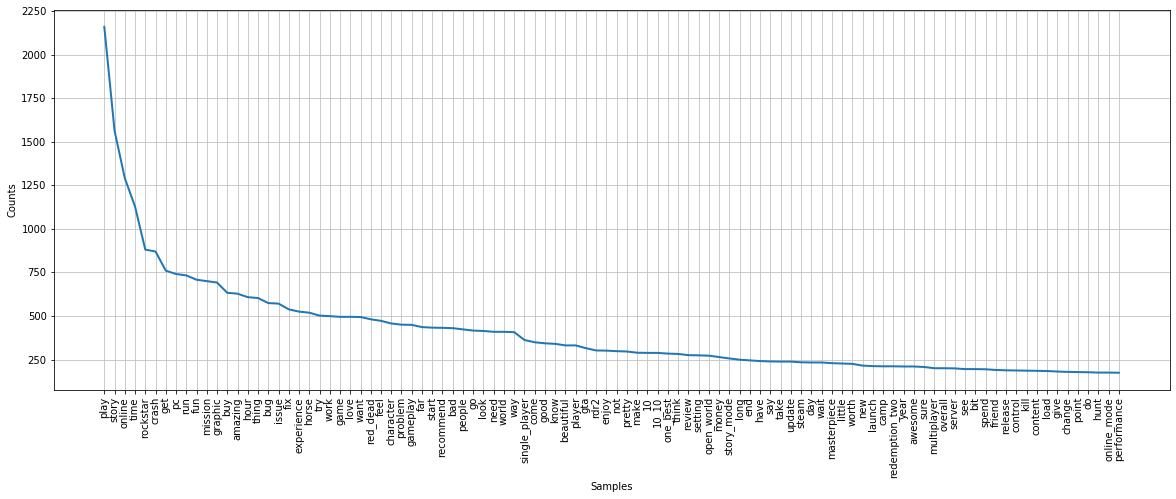

In [295]:
wordfreq_2gram = nltk.FreqDist(word_lst_2gram)
# Print the most common words.
plt.figure(figsize=(20,7))
wordfreq_2gram.plot(100,cumulative=False)

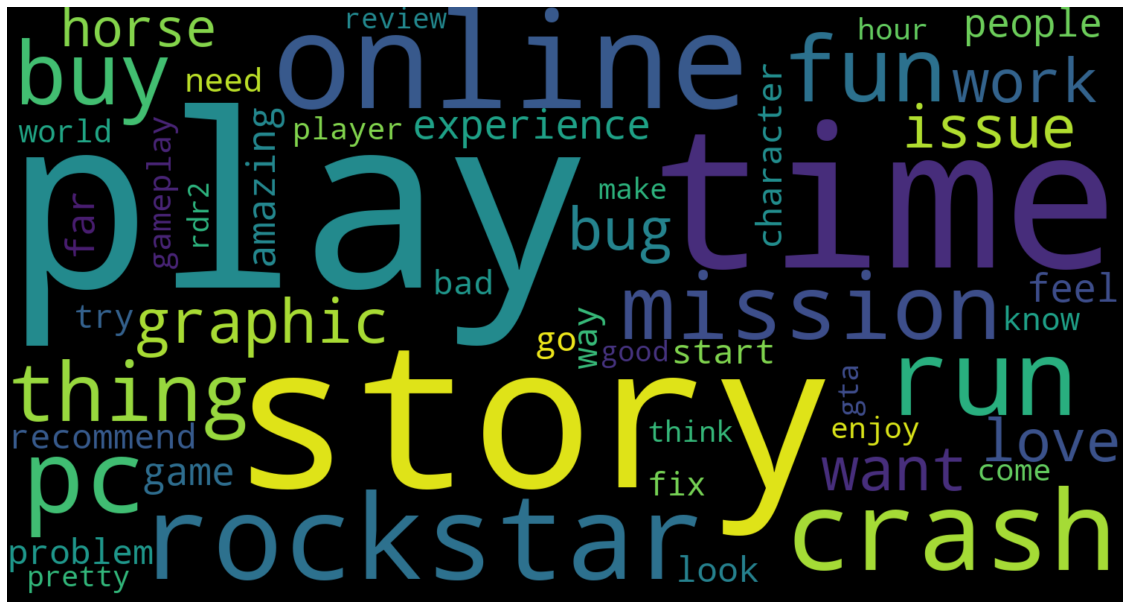

In [296]:
#generate wordcloud for 3grams
text_3grams = ' '.join(w for w in word_lst_3gram)

# Create and generate a word cloud image
wcd = wordcloud.WordCloud(width = 1500, height=800, max_words = 50).generate(text_3grams)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

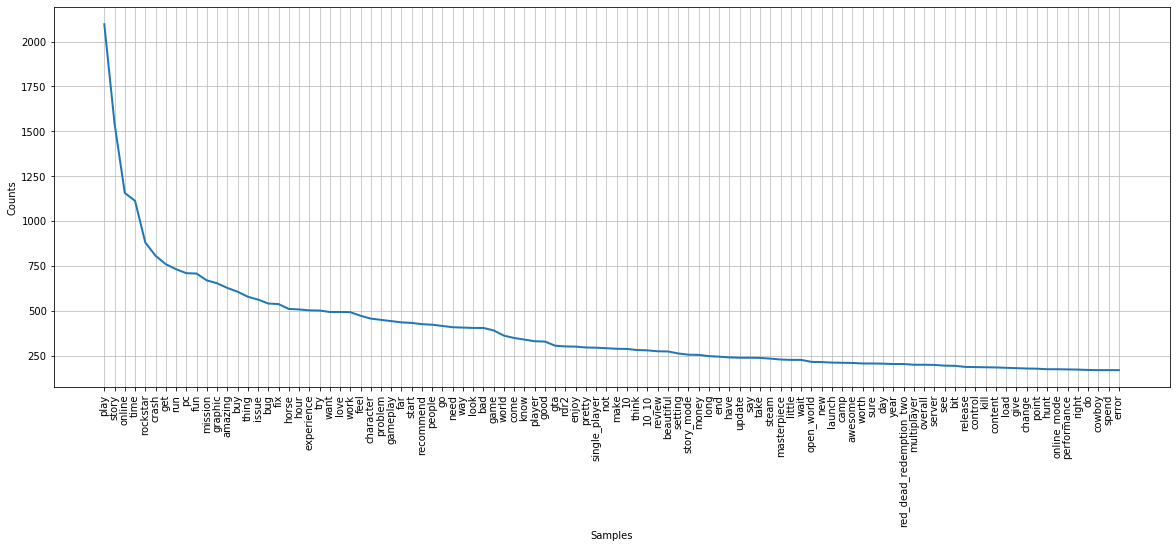

In [297]:
wordfreq_3gram = nltk.FreqDist(word_lst_3gram)
# Print the most common words.
plt.figure(figsize=(20,7))
wordfreq_3gram.plot(100,cumulative=False)

### N-grams may make topics more coherent

Coherent n-grams such as 'best_total_war' have appeared. 

Gameplay features such as 'romance_mode' (the less historically-authentic version based on the novel Romance of the Three Kingdoms) have appeared as n-gram terms.

**Next steps:**
- Try LDA first and if topics are coherent. 
    - If not, further cleaning may be needed.  
    - It may reduce noise if we remove terms that appear across multiple topics.
- 3grams seem to be most coherent, so we will use 3grams for LDA.